In [3]:
from __future__ import print_function
from __future__ import division

import numpy as np
from numpy import *

import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim


import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

from skimage import data, io, filters

from matplotlib.path import Path
import matplotlib.patches as patches

In [4]:
# use_cuda = torch.cuda.is_available()
# dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [5]:
path_to_strokes =  "tiny/airplane.npy"
X = np.load(path_to_strokes)[()]

In [6]:
print('Example sketch has ', str(shape(X['airplane'][0][0])[0]), ' strokes')
print('Corresponds to photo: ', X['airplane'][1][0])

path_to_source_photos = "../tiny/photo/airplane/"
photo = os.path.join(path_to_source_photos,'n02691156_10151.jpg')

Example sketch has  169  strokes
Corresponds to photo:  n02691156_10151


In [7]:
class TinyDataset(torch.utils.data.Dataset):
    """tiny airplane dataset of photos and sketches for pix2svg."""

    def __init__(self, npy_file, root_dir, transform=None):
        """
        Args:
            npy_file (string): Path to the numpy file with stroke-5 representation and corresponding photos.
                    # to get stroke-5 representation of svg
                    x['airplane'][0][5]
                    # to get corresponding photos
                    x['airplane'][1][5]
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.stroke_dir = npy_file
        self.photo_dir = os.path.join(root_dir,'photo')
        self.strokes = np.load(npy_file)[()]
        self.transform = transform
    
    def __len__(self):
        return len(self.strokes['airplane'][0])

    def __getitem__(self, idx):
        img_name = os.path.join(self.photo_dir,'airplane',X['airplane'][1][idx]+ '.jpg')
        photo = io.imread(img_name)
        photo = photo.astype(float)
#         photo = np.reshape(photo,(3,256,256)) # reshape to what pytorch expects
        strokes = self.strokes['airplane'][0][idx]
        sample = {'photo': photo, 'strokes': strokes,'name': X['airplane'][1][idx]+ '.jpg'}
        
        if self.transform:
            sample = self.transform(sample)

        return sample    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, strokes, name = sample['photo'], sample['strokes'], sample['name']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))        
        return {'tensor': torch.from_numpy(image).div(255),
                'strokes': strokes,
                'name': name,
                'photo': image}    

def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result    
    
def strokes_to_lines(strokes):
    """
    Convert stroke-3 format to polyline format.
    List contains sublist of continuous line segments (strokes).    
    """
    x = 0
    y = 0
    lines = []
    line = []
    for i in range(len(strokes)):
        if strokes[i, 2] == 1:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
            lines.append(line)
            line = []
        else:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
    return lines

def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.LINETO) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y)            
    return verts, codes

def path_renderer(verts, codes):
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2)
    ax.add_patch(patch)
    ax.set_xlim(0,max(max(verts)))
    ax.set_ylim(0,max(max(verts)))
    ax.axis('off')
    plt.gca().invert_yaxis() # y values increase as you go down in image
    plt.show()

In [8]:
## load in airplanes dataset
airplanes = TinyDataset(npy_file='/home/jefan/ptsketchy/tiny/airplane.npy',root_dir='/home/jefan/ptsketchy/tiny',transform=None)

300 (256, 256, 3) (86, 5)


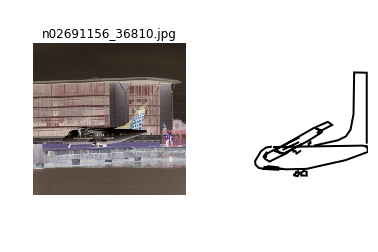

In [19]:
## display given photo and corresponding sketch from stroke-5 representation
i = 300
sample = airplanes[i]
print(i, sample['photo'].shape, sample['strokes'].shape)

plt.figure()
ax = plt.subplot(121)
ax.set_title(sample['name'])
ax.axis('off')
img = np.reshape(sample['photo'],(256,256,3))
plt.imshow(img,interpolation='nearest')

ax = plt.subplot(122)
lines = strokes_to_lines(to_normal_strokes(sample['strokes']))
verts,codes = polyline_pathmaker(lines)
path_renderer(verts,codes)

plt.show()

array([[[194, 206, 220],
        [196, 208, 220],
        [195, 207, 219],
        ..., 
        [214, 221, 231],
        [212, 221, 230],
        [210, 219, 228]],

       [[194, 206, 220],
        [196, 208, 220],
        [197, 210, 219],
        ..., 
        [213, 220, 230],
        [211, 220, 229],
        [210, 219, 228]],

       [[196, 208, 220],
        [197, 209, 221],
        [200, 210, 220],
        ..., 
        [212, 221, 228],
        [212, 221, 228],
        [211, 220, 227]],

       ..., 
       [[158, 172, 183],
        [156, 170, 181],
        [158, 172, 183],
        ..., 
        [142, 156, 167],
        [143, 155, 167],
        [147, 159, 171]],

       [[159, 175, 188],
        [158, 174, 187],
        [151, 167, 180],
        ..., 
        [147, 164, 174],
        [146, 160, 171],
        [144, 158, 169]],

       [[150, 166, 179],
        [148, 164, 177],
        [147, 165, 177],
        ..., 
        [148, 165, 173],
        [151, 165, 176],
        [147, 161,

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be atleast 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

In [82]:
# ## load in airplanes dataset
# airplanes = TinyDataset(npy_file='/home/jefan/ptsketchy/tiny/airplane.npy',
#                         root_dir='/home/jefan/ptsketchy/tiny',
#                         transform=transforms.Compose([ToTensor(), _Normalize()]))

# load in airplanes dataset
airplanes = TinyDataset(npy_file='/home/jefan/ptsketchy/tiny/airplane.npy',
                        root_dir='/home/jefan/ptsketchy/tiny',
                        transform=transforms.Compose([ToTensor()]))

In [85]:
# data loader
data_loader = torch.utils.data.DataLoader(
    airplanes,
    batch_size=1, shuffle=False,
    num_workers=4, pin_memory=True)

In [91]:
model = models.alexnet(pretrained=True)


In [92]:
model

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [90]:
model.features()

AttributeError: 'DataParallel' object has no attribute 'features'

In [112]:
net = models.alexnet(pretrained=True).features

class FeatureExtractor(nn.Module):
    def __init__(self, submodule, extracted_layers):
        self.submodule = submodule

    def forward(self, x):
        outputs = []
        for name, module in self.submodule._modules.items():
            x = module(x)
            if name in self.extracted_layers:
                outputs += [x]
        return outputs + [x]

new_net = nn.Sequential().cuda() # the new network
other_net = nn.Sequential().cuda() # another network

target_layers = ['conv_1', 'conv_2', 'conv_4'] # layers you want to extract`

i = 1
for layer in list(net):
    if isinstance(layer,nn.Conv2d):
        name = "conv_"+str(i)
        new_net.add_module(name,layer)

        if name in target_layers:
            other_net.add_module("extractor_"+str(i),FeatureExtractor())

        i+=1

    if isinstance(layer,nn.ReLU):
        name = "relu_"+str(i)
        new_net.add_module(name,layer)

    if isinstance(layer,nn.MaxPool2d):
        name = "pool_"+str(i)

TypeError: __init__() takes exactly 3 arguments (1 given)

In [131]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

imsize = 224  # desired size of the output image

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


image_name = os.path.join('/home/jefan/ptsketchy/tiny/photo/airplane',airplanes[0]['name'])

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


content = image_loader(image_name).type(dtype)

# target = model.forward(content)

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /b/wheel/pytorch-src/torch/lib/THC/generic/THCStorage.cu:66

In [125]:
net = models.alexnet(pretrained=True).features

class FeatureExtractor(nn.Module):
    def forward(self, input):
        self.feature = input.clone()
        return input

new_net = nn.Sequential() # the new network

target_layers = ['conv_1', 'conv_2', 'conv_4'] # layers you want to extract`

i = 1
for layer in list(net):
    if isinstance(layer,nn.Conv2d):
        name = "conv_"+str(i)
        new_net.add_module(name,layer)

        if name in target_layers:
            new_net.add_module("extractor_"+str(i),FeatureExtractor())

        i+=1

    if isinstance(layer,nn.ReLU):
        name = "relu_"+str(i)
        new_net.add_module(name,layer)

    if isinstance(layer,nn.MaxPool2d):
        name = "pool_"+str(i)
        new_net.add_module(name,layer)

In [ ]:
# new_net.forward(content)
# print(new_net.extractor_3.feature)

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /b/wheel/pytorch-src/torch/lib/THC/generic/THCStorage.cu:66